# Lecture 4 - Classifiers Demo
## Logistic regression, support vector machine, decision trees, bagging, boosting
Author: Kaihang Zhang<br>
 khzhang2@connect.hku.hk <br>
208 Haking Wong Building<br>
Department of Civil Engineering<br>
The University of Hong Kong<br>
December 24, 2022<br>

In [1]:
##################################################################################################################
##      Script template created for the course CIVL 7018 at The University of Hong Kong.                        ##
##      in Spring 2023 semester                                                                                 ##
##      Licensing Information:  You are free to use or extend this project if:                                  ##
##          (1) You don't distribute or publish coding solutions for CIVL 7018 Assignments online.              ##
##          (2) You retain this notice.                                                                         ##
##          (3) You provide clear attribution to The University of Hong Kong                                    ##
##################################################################################################################

## Problem Description

Consider again the probability of a student passing an exam.

A group of 20 students spend between 0 and 6 hours studying for an exam. How does the number of hours spent studying affect the probability that the student will pass the exam? The table shows the number of hours each student spent studying, and whether they passed (1) or failed (0).

Additionally, we consider a second variable, the previous passing rate, which is the number of courses a student has taken and passed divided by total number of courses that student has taken. 

The data is summarized in the table below.

## Data

|Student ID|Study Hours|Prev. Pass Rate|Pass?|
|---       |---        |---            |---  |
|1         |0.5        |0.4            |0|
|2         |0.75       |0.3            |0|
|3         |1          |0.6            |0|
|4         |1.25       |0.4            |0|
|5         |1.5        |0.7            |0|
|6         |1.75       |0.4            |0|
|7         |1.75       |1.0            |1|
|8         |2          |0.3            |0|
|9         |2.25       |0.9            |1|
|10        |2.5        |0.4            |0|
|11        |2.75       |0.7            |1|
|12        |3          |0.3            |0|
|13        |3.25       |0.6            |1|
|14        |3.5        |0.2            |0|
|15        |4          |0.7            |1|
|16        |4.25       |0.5            |1|
|17        |4.5        |0.7            |1|
|18        |4.75       |0.8            |1|
|19        |5          |0.7            |1|
|20        |5.5        |0.8            |1|

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
seed = 15

In [3]:
data = np.array([
        [1         ,0.5        ,0.4            ,0],
        [2         ,0.75       ,0.3            ,0],
        [3         ,1          ,0.6            ,0],
        [4         ,1.25       ,0.4            ,0],
        [5         ,1.5        ,0.7            ,0],
        [6         ,1.75       ,0.4            ,0],
        [7         ,1.75       ,1.0            ,1],
        [8         ,2          ,0.3            ,0],
        [9         ,2.25       ,0.9            ,1],
        [10        ,2.5        ,0.4            ,0],
        [11        ,2.75       ,0.7            ,1],
        [12        ,3          ,0.3            ,0],
        [13        ,3.25       ,0.6            ,1],
        [14        ,3.5        ,0.2            ,0],
        [15        ,4          ,0.7            ,1],
        [16        ,4.25       ,0.5            ,1],
        [17        ,4.5        ,0.7            ,1],
        [18        ,4.75       ,0.8            ,1],
        [19        ,5          ,0.7            ,1],
        [20        ,5.5        ,0.8            ,1],
])
np.random.seed(seed)
# shuffle the data
np.random.shuffle(data)
data_df = pd.DataFrame(data, columns=['ID', 'Hours', 'Prev', 'if_Pass'])
# seperate the data into a training set (first 70%) and a validation set (last 30%)
data_df_train = data_df.iloc[:10, :]
data_df_val = data_df.iloc[10:, :]


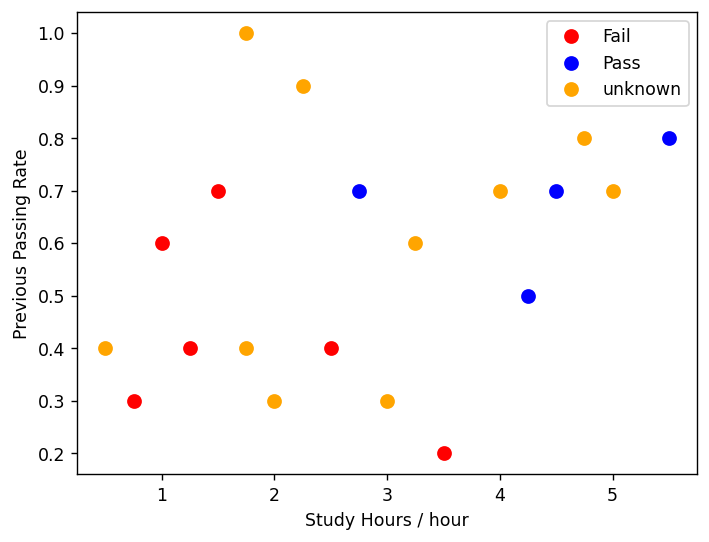

In [4]:
# visualization
plt.figure(dpi=125)
plt.plot(data_df_train.loc[data_df['if_Pass']==0, 'Hours'], data_df_train.loc[data_df['if_Pass']==0, 'Prev'], 'r.', markersize=15, label='Fail')
plt.plot(data_df_train.loc[data_df['if_Pass']==1, 'Hours'], data_df_train.loc[data_df['if_Pass']==1, 'Prev'], 'b.', markersize=15, label='Pass')
plt.plot(data_df_val['Hours'], data_df_val['Prev'], '.', color='orange', markersize=15, label='unknown')
plt.xlabel('Study Hours / hour')
plt.ylabel('Previous Passing Rate')
plt.legend()



In [5]:
data_df_train

,ID,Hours,Prev,if_Pass
0,20.0,5.50,0.8,1.0
1,16.0,4.25,0.5,1.0
2,4.0,1.25,0.4,0.0
3,10.0,2.50,0.4,0.0
4,5.0,1.50,0.7,0.0
5,3.0,1.00,0.6,0.0
6,11.0,2.75,0.7,1.0
7,17.0,4.50,0.7,1.0
8,14.0,3.50,0.2,0.0
9,2.0,0.75,0.3,0.0


In [6]:
data_df_val

,ID,Hours,Prev,if_Pass
10,7.0,1.75,1.0,1.0
11,18.0,4.75,0.8,1.0
12,15.0,4.00,0.7,1.0
13,8.0,2.00,0.3,0.0
14,12.0,3.00,0.3,0.0
15,19.0,5.00,0.7,1.0
16,1.0,0.50,0.4,0.0
17,6.0,1.75,0.4,0.0
18,13.0,3.25,0.6,1.0
19,9.0,2.25,0.9,1.0


In [7]:
# define a function for calculating classification accuracy
def cal_acc(pred, y):
    pred = np.array(pred).flatten()
    y = np.array(y).flatten()
    return np.sum(pred==y) / pred.shape[0]

## Logistic Regression
### This section, we conly consider the number of studied hours. 
You are encouraged to read this content (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) before going on.

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
X = data_df_train['Hours'].to_numpy().reshape(-1, 1)
y = data_df_train['if_Pass'].to_numpy()
# make sure that there is no regulation term by setting penalty='none'
clf = LogisticRegression(random_state=seed, penalty='none').fit(X, y)


In [10]:
print('w0', clf.intercept_)
print('w1', clf.coef_)


w0 [-6.37033981]
w1 [[1.98442536]]


In [11]:
pred = clf.predict(data_df_val['Hours'].values.reshape(-1, 1))
y = data_df_val['if_Pass']
print('The prediction accuracy for logistic regression is {:.4}%'.format(cal_acc(pred, y)*100))

The prediction accuracy for logistic regression is 80.0%


## Support Vector Machine
You are encouraged to read this content (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) before going on.

In [12]:
from sklearn.svm import SVC

In [13]:
X = data_df_train[['Hours', 'Prev']]
y = data_df_train['if_Pass']
clf = SVC(C=100, kernel='linear').fit(X, y)  # make C larger, reduce regularization


In [14]:
print('w0', clf.intercept_)
print('w1 w2', clf.coef_)

w0 [-7.87898585]
w1 w2 [[1.60000317 6.39808405]]


In [15]:
pred = clf.predict(data_df_val[['Hours', 'Prev']])
y = data_df_val['if_Pass']
print('The prediction accuracy for support vector machine is {:.4}%'.format(cal_acc(pred, y)*100))

The prediction accuracy for support vector machine is 100.0%


x_min 0.25 x_max 5.75
y_min 0.16 y_max 1.04


/opt/anaconda3/envs/modeling/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


(0.16, 1.04)

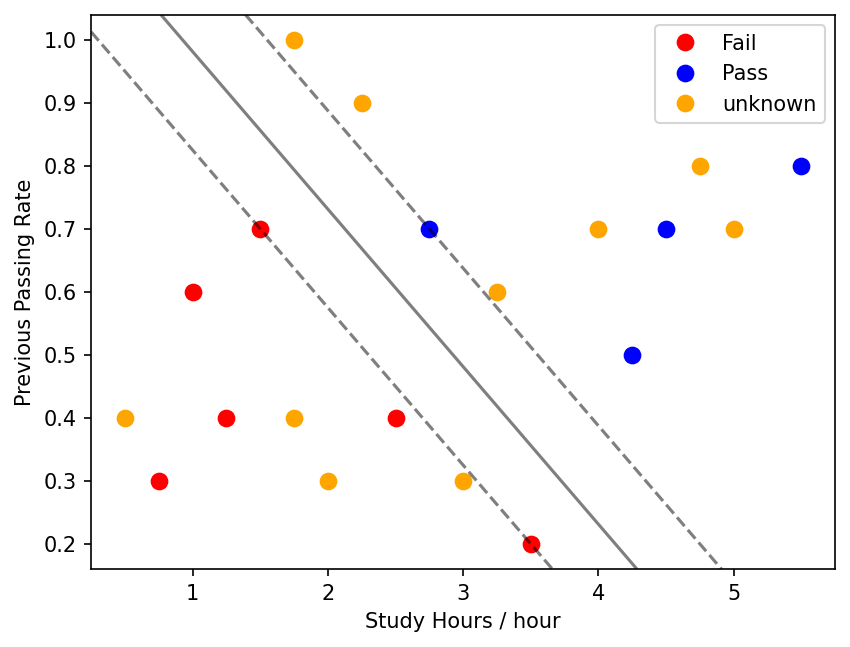

In [16]:
## visualization
# plot hyperplane
x1 = data_df_train['Hours'].to_numpy()
x2 = data_df_train['Prev'].to_numpy()
y = data_df_train['if_Pass'].to_numpy()

plt.figure(dpi=150)
plt.plot(data_df_train.loc[data_df_train['if_Pass']==0, 'Hours'], data_df_train.loc[data_df_train['if_Pass']==0, 'Prev'], 'r.', markersize=15, label='Fail')
plt.plot(data_df_train.loc[data_df_train['if_Pass']==1, 'Hours'], data_df_train.loc[data_df_train['if_Pass']==1, 'Prev'], 'b.', markersize=15, label='Pass')
plt.plot(data_df_val['Hours'], data_df_val['Prev'], '.', color='orange', markersize=15, label='unknown')
plt.xlabel('Study Hours / hour')
plt.ylabel('Previous Passing Rate')
plt.legend()

ax = plt.gca()  # obtain current subplot

# obtain the axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()
print('x_min {:.2f}'.format(xlim[0]), 'x_max {:.2f}'.format(xlim[1]))
print('y_min {:.2f}'.format(ylim[0]), 'y_max {:.2f}'.format(ylim[1]))

# plot the hyperplane
axisx = np.linspace(xlim[0], xlim[1], 50)
axisy = np.linspace(ylim[0], ylim[1], 50)
axisx, axisy = np.meshgrid(axisx, axisy)
xy = np.vstack([axisx.ravel(), axisy.ravel()]).T

Z = clf.decision_function(xy).reshape(axisx.shape)

ax.contour(axisx, axisy, Z
           ,colors="k"
           ,levels=[-1, 0, 1] # draw three contours, for 1, 0, and -1
           ,alpha=0.5# transparancy
           ,linestyles=["--","-","--"])

# set axis limitations
ax.set_xlim(xlim)
ax.set_ylim(ylim)


## Decision Trees
A comprehensive intrduction of Decision Trees method is available via this link (https://scikit-learn.org/stable/modules/tree.html), provided by scikit-learn developers.

This section mainly adopts the part 1.10.1 of this documentation to our problem.

In [17]:
from sklearn import tree

In [18]:
X = data_df_train[['Hours', 'Prev']]
y = data_df_train['if_Pass']
clf = tree.DecisionTreeClassifier(random_state=seed)
clf = clf.fit(X, y)


[Text(0.4, 0.8333333333333334, 'X[0] <= 2.625\ngini = 0.48\nsamples = 10\nvalue = [6, 4]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.6, 0.5, 'X[1] <= 0.35\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]')]

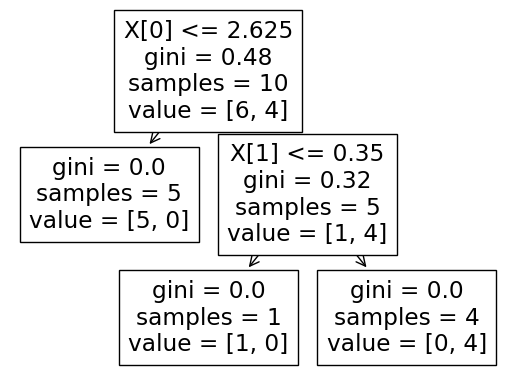

In [19]:
tree.plot_tree(clf)

In [20]:
pred = clf.predict(data_df_val[['Hours', 'Prev']])
y = data_df_val['if_Pass']
print('The prediction accuracy for decision trees is {:.4}%'.format(cal_acc(pred, y)*100))

The prediction accuracy for decision trees is 80.0%


## Bagging, Random Forest, and Boosting
These are clustered into Ensemble methods, which is comprehensively intrduced by scikit-learn developers (https://scikit-learn.org/stable/modules/ensemble.html). A list of supported ensembling methods on sklearn can be found here (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble). 

This section mainly adopts some methods in this documentation to our problem.


### Bagging
As introduced in lecture, bagging is an abbreviation for bootstrap aggregating.

You are encouraged to read this documentation content (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) before going on. 

The figure is adopted from Wikipedia (https://en.wikipedia.org/wiki/Out-of-bag_error).
<img src="./img/bagging_illustration.png" width=600>

In [21]:
from sklearn.ensemble import BaggingClassifier

X = data_df_train[['Hours', 'Prev']]
y = data_df_train['if_Pass']
# A base cllasifier should be claimed before using bagging
# if there is no such claimed, a DecisionTreeClassifier will
# be used as the base classifier.
# You can check the documentation for details.
clf = BaggingClassifier(random_state=seed)
clf.fit(X, y)

BaggingClassifier(random_state=15)

In [22]:
pred = clf.predict(data_df_val[['Hours', 'Prev']])
y = data_df_val['if_Pass']
print('The prediction accuracy for bagging with decision trees as base model is {:.4}%'.format(cal_acc(pred, y)*100))


The prediction accuracy for bagging with decision trees as base model is 90.0%


#### Random Forest
You are encouraged to read this documentation content (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) before going on. 

Note: if all the variables are considered in the random forest, then it becomes bagging (using decision tree classifier). This can be achieved by setting max_features=None. You can check the documentation for details. 

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
X = data_df_train[['Hours', 'Prev']]
y = data_df_train['if_Pass']
clf = RandomForestClassifier(random_state=seed)
clf.fit(X, y)

RandomForestClassifier(random_state=15)

In [25]:
pred = clf.predict(data_df_val[['Hours', 'Prev']])
y = data_df_val['if_Pass']
print('The prediction accuracy for random forest is {:.4}%'.format(cal_acc(pred, y)*100))


The prediction accuracy for random forest is 90.0%


### Boosting
#### Adaboost
An abbreviation for adaptive boosting. You are encouraged to read this documentation content (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) before going on. 

In [26]:
from sklearn.ensemble import AdaBoostClassifier

In [27]:
X = data_df_train[['Hours', 'Prev']]
y = data_df_train['if_Pass']
clf = AdaBoostClassifier(random_state=seed)
clf.fit(X, y)

AdaBoostClassifier(random_state=15)

In [28]:
pred = clf.predict(data_df_val[['Hours', 'Prev']])
y = data_df_val['if_Pass']
print('The prediction accuracy for adaboost is {:.4}%'.format(cal_acc(pred, y)*100))


The prediction accuracy for adaboost is 70.0%


#### Gradient Boosting Decision Tree (GBDT)
You are encouraged to read this documentation content (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) before going on.

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

In [30]:
X = data_df_train[['Hours', 'Prev']]
y = data_df_train['if_Pass']
clf = GradientBoostingClassifier(random_state=seed)
clf.fit(X, y)

GradientBoostingClassifier(random_state=15)

In [31]:
pred = clf.predict(data_df_val[['Hours', 'Prev']])
y = data_df_val['if_Pass']
print('The prediction accuracy for GBDT is {:.4}%'.format(cal_acc(pred, y)*100))


The prediction accuracy for GBDT is 80.0%
